# Project Milestone 05 (NE 591) - Parallel Diffusion Code
- **Author**: Kirill Shumilov
- **Date**: Fri, March 21, 2025

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

analysis_dir = pathlib.Path('.').absolute()
examples_dir = analysis_dir.parent / 'examples'
tests_dir = analysis_dir / 'tests'
executable = analysis_dir.parent / 'shumilov_project02'

# 1. Description of Work

In this project milestone, we implement Parallel Point-Jacobi algorithm to solving a finite-difference 2D Neutron Diffusion problem in a non-multiplying medium. To acheive this task, two major ideas are used:

1. Partitioning of the source/flux matrices among processes

Both the source and the flux matrices are partioned into blocks of appropriate size and distributed among processes, arranged in a 2D cartesian topology. At each iteration, each process updates its flux block according to serial PJ algorithm. At the end of each iteration, each process distributes its halo, a region of single-cell wide among the neigbhoring cells. The distributions is done in checker-board style. This means that each process on 2D grid is colored into "red" and "blue" colors, such that each "red" process boarders only "blue" processes. During the halo update, "blue" processes chare their halo with boardering "red" first. Once the data exchange is complete, the processes shift roles: now "red" processes share their halos. This allows to exchange data in a non-blocking way.

2. Applying the operator $A$ (from $Ax=b$) using the stencil method. 

The diffusion equation can be written in the form:
\begin{equation}
-D\left[\frac{\phi_{i+1,j}-2\phi_{i,j}+2\phi_{i+1,j}}{\delta^2} + \frac{\phi_{i,j-1}-2\phi_{i,j}+2\phi_{i,j + 1}}{\gamma^2}\right] + \Sigma_a\phi_{i,j} = q_{ij}
\end{equation}
where $D$ is the diffusion factor, $\Sigma_a$ - the macroscopic absorption cross-section, $q_{i,j}$ is the source strenght in the cell $(x_i,y_j)$, $\phi_{i,j}$ is the scalar flux in the cell $(x_i,y_j)$, and $\delta$ and $\gamma$ are the cell sizes in $x$ and $y$ respectively. This produces a matrix with only 5 non-zero diagonals.

Therefore, it is not necessary to store the entire matrix, but only the way to update the flux value based on its neighbors, using the constants found in the equation. This means that at every iteration the following the next flux iterate of flux is obtained usin:
\begin{equation}
\phi_{i,j}^{(k + 1)} = \phi_{i,j}^{(k)} + \frac{1}{s^{(c)}_{i,j}}\left(q_{i, j} - (s^{(b)}_{i,j}\phi_{i-1,j}^{(k)} + s^{(t)}_{i,j}\phi_{i+1,j}^{(k)} + s^{(l)}_{i,j}\phi_{i,j-1}^{(k)} + s^{(r)}_{i,j}\phi_{i,j-1}^{(k)})\right)
\end{equation}
where $s^{(c)}_{i,j}=\Sigma_a + 2D\left(\delta^{-2} + \gamma^{-2}\right)$, $s^{(l)}_{i,j} = s^{(r)}_{i,j} = -D\gamma^{-2}$, and $s^{(t)}_{i,j} = s^{(b)}_{i,j} = -D\delta^{-2}$

# 2. Numerical Experiments

Two major experiments are conducted to verify the correctness and scaling of the code:

1. Comparison against LUP methods and serial version from Milestone #2.

A small system of $n = 12$ is used to compare the resulting flux from LUP, Serial PJ, Parallel PJ.

2. Timing measurements as a function of $n$ - the size of the system, and $P$ - number of processors used.

To complete the second experiment, we selected four system with sizes $n=\{128, 256, 512, 1024\}$, uniformly spaced grids and unit $D=1$, and $\Sigma_a=0.1$. The systems have a singular point source located in the top left corner of the rectangular region. The solutions, $\phi_{i,j}$ are shown above for each system. All iterative methods were allowd to run for maximum of $500,000$ iterations with tolerance of $10^{-5}$ and relaxation fractor 1.905 (for SOR).


In [6]:
from utils import Grid, System, Parameters, Inputs

grid_sizes = [128, 256, 512, 1024]


def generate_input_file(n: int) -> None:
    params = Parameters('gs', 1e-5, 500_000, 1.95)

    system = System.from_point_sources(
        Grid.build_square(10, n),
        locs=(2.5, 2.5),
        fwhms=1.0,
        D=1, S=0.1
    )

    inputs = Inputs(params, system)

    filepath = tests_dir / f'g{n}_{params.algorithm}.inp'
    inputs.to_txt(filepath)

    return inputs


inputs = []
for n in grid_sizes:
    inp = generate_input_file(n)
    inputs.append(inp)

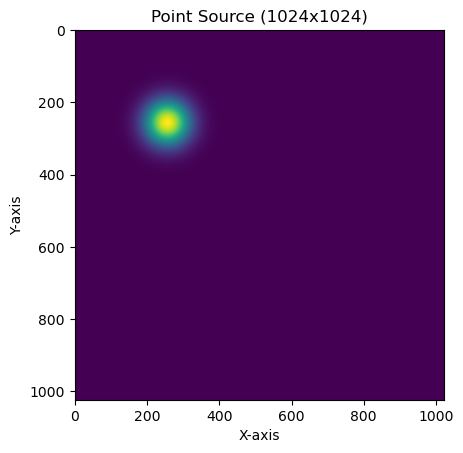

In [4]:
inp = inputs[-1]
img = plt.imshow(inp.system.source, cmap='viridis')  # Use 'viridis' colormap
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

n = inp.system.grid.M
plt.title(f"Point Source ({n}x{n})")
plt.show()

# 3. Results

## Verification
Verification according to the first experiment has been completed. The result flux and absolute residual are identifcal between Parallel and Serial PJ codes (wrt to Project 02), providing the same relative error of ~1e5 wrt to LUP.

## Timing Scaling

Below is the table with the results of the calculations. All systems converged, have the exact same number of iterations, relative error, and residual error, for each respective $n$, independent of $p$, which points that our implementation is synchronous.

In [54]:
df = pd.read_csv(tests_dir / 'data.csv', index_col=0)
df.reset_index(inplace=True)
df

,p,n,iters,time,iter_error,res_err
0,1,128,13051,2.408801,0.00001,0.000058
1,1,256,39703,21.469733,0.00001,0.000225
2,1,512,111497,53.295766,0.00001,0.000854
3,1,1024,278576,275.428040,0.00001,0.003090
4,4,128,13051,0.821272,0.00001,0.000058
5,4,256,39703,7.393507,0.00001,0.000225
6,4,512,111497,11.971554,0.00001,0.000854
7,4,1024,278576,37.578655,0.00001,0.003090
8,16,128,13051,0.414304,0.00001,0.000058
9,16,256,39703,2.928991,0.00001,0.000225


## Execution time

Below is the plot of execution time as a function of number of processors used to solve the problem.
It can be seen that generally that larger problems result in longer execution time.
There is a general downward trend with increase of number of processors. However, there are some exceptions.
It should be noted that there's a lot of variability in time measuremnts, which can be explained by the local state of the machine and network at the moment of the measurement.

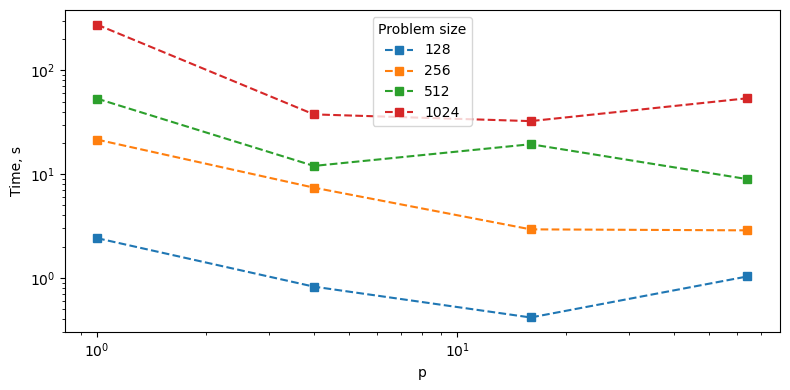

In [50]:
fig, axes = plt.subplots(1, 1, layout='tight', figsize=(8, 4))

for algo, dfa in df.groupby('n'):
    axes.loglog('p', 'time', 's--', data=dfa, label=algo)

axes.legend(title='Problem size')
axes.set_xlabel('p')
axes.set_ylabel('Time, s')

plt.show()

# 4. Discussion

The implementation has been verified to be both correct and synchronous. The "general" reduction of executation time is visiable by in the graph above, however, it is obscured by the large variability of the associated with each data point. 
Another explanation for the "upticks" can be explained by the rising "cost" of maintaining communication between large number of processor. The update of halo gets more expensive with the growing number of processors. And it becomes expecially prominent when the block size becomes comparable to the halo size. This observation points to an existence of optimal number of processors for the given problem size, aka "less" is sometimes "more".

# 5. Conclusion

We have implemented solution of finite difference methods using parallel Point-Jacobi algorith. Using the stencil and checker-board techniques, we were able to achieve synchronous parallel implementation, which numerially is practically indistinguishible from the serial code. We have observed reduction of execution time with the number of processors used. However, this general trend is obscured by the inefficiency of process-to-process communication and the state of compute machine and network at the moment of computation.